# Homework 4

## Preliminary Steps

We start the homework by importing the (many!) needed libraries and define functions that will help us later in the homework.

In [1]:
#We import the same libraries as in the 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV, PredefinedSplit

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline

The first function allows us to draw custom charts (and display them inline to be able to get useful insights). This will be used a lot throughout Exercise 1.

In [2]:
#we use this a lot :D
def drawPies(u_rates, t_rates, labels, supertitle):
    """draws pretty comparative pie charts
    u_rates : rates for untreated group
    t_rates : rates for treated group
    lables: labels for values in rates
    supertitle: title of chart
    """
    fig = plt.figure(figsize=(7, 7))
    fig.suptitle(supertitle)
    
    plt.subplot(2,2,1)
    plt.pie(u_rates, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.title("untreated group")

    plt.subplot(2,2,2)
    plt.pie(t_rates, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.title("treated group")
    plt.show()

The second function we define is used to compare the interval variables (cf Exercises 1.02 and 1.04) of a DataFrame.

In [3]:
def interval_plots(df):
    """constructs boxplot and relative frequency histogram for data frame
    df: dataframe to be analyzed
    """
    #for each column draw a Boxplot
    for col in intervals:
        plt.figure(figsize=(10, 10))
        treated_ = df[treated(df)][col]
        untreated_ = df[untreated(df)][col]

        #boxplot
        plt.subplot(2,2,1)
        plt.title("Boxplot of " + col)
        plt.boxplot([untreated_, treated_], 
                    labels=['untreated', 'treated'], showfliers=False)
        plt.ylabel(col)

        #histogram
        plt.subplot(2,2,2)
        bins = np.linspace(min(df[col]), max(lalonde_df[col]), 50)
        plt.title("Relative frequency histogram of " + col)
        plt.ylabel('percentage')
        plt.xlabel(col)
        plt.hist(untreated_, weights=np.ones(len(untreated_))/len(untreated_), alpha=.5 , bins=bins)
        plt.hist(treated_, weights=np.ones(len(treated_))/len(treated_), alpha=.5, bins=bins)
        plt.legend(['untreated', 'treated'])

This final function is used in exercise 1.05 in order to compare the probabilities of categorical data between both groups (treated and untreated).

In [4]:
def compare_groups(table) :
    """
    Compares groups in merged dataframe
    table : dataframe to compare treated and untreated in
    """
    columns = ['untreated', 'treated']
    index = ['black', 'hisp', 'married', 'no_degree']
    result = pd.DataFrame(columns=columns, index=index)
    result['untreated']['black'] = table['black_y'].mean()
    result['untreated']['hisp'] = table['hispan_y'].mean()
    result['untreated']['married'] = table['married_y'].mean()
    result['untreated']['no_degree'] = table['nodegree_y'].mean()
    result['treated']['black'] = table['black_x'].mean()
    result['treated']['hisp'] = table['hispan_x'].mean()
    result['treated']['married'] = table['married_x'].mean()
    result['treated']['no_degree'] = table['nodegree_x'].mean()
    return result

## Exercise 1: Propensity Score Matching

The idea of this exercise is to analyze a dataset first without any real knowledge (naive analysis) and then through multiple processing steps to understand the data further.

We start by importing the data (and displaying it to understand the format).

In [5]:
lalonde_df = pd.read_csv('lalonde.csv')
lalonde_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Using this data, we can easily imagine that the first thing we need to do is split the salary data (_['re78']_) into 2 sets: treated and untreated. This will be useful throughout the exercise.

In [6]:
#masks to be used
treated = (lambda x: x.treat == 1)
untreated = (lambda x: x.treat == 0)

#mask application to the first DF
treated_salary = lalonde_df[treated(lalonde_df)]['re78']
untreated_salary = lalonde_df[untreated(lalonde_df)]['re78']

### 1. A naive analysis

We assume that a naive researcher unfamiliar with observational studies would treat the data as a randomized trial, not taking into consideration the hidden correlates.

**i - Describing the numbers**

We first look at the numbers to see how many subjects we have in each group and to see how the values are distributed.

In [7]:
lalonde_df.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,6984.169742,7294.161791,0.0,220.1813,4975.505,11688.820,25564.67
1,185.0,6349.143530,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


##### First insights:

- The untreated group has more people and their salaries have a higher mean.
- However, the 1st salary quartile is twice higher in the treated group and the maximum salary is 3x higher!
- We have that the 2nd and 3rd quartiles are higher in the untreated group. Quartiles are more resistent to outliers, hence indicating that the untreated group is faring better.
- Finally, the interquartile distance is larger in the untreated set (because of outliers). We use this measure because it is better to measure _'variance'_. Thus, we can say that the untreated group has a more heterogenous salary distribution.

**ii - Visualizing the data:**

We now plot the _['re78']_ salary data in a histogram (with equal sized bins) to find the distribution of salaries of the two groups. We add weights to be able to look at percentages instead of at the number of people in both groups (not equal, meaning it is not informative).

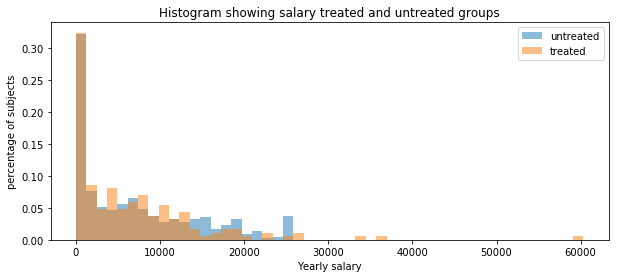

In [8]:
plt.figure(figsize=(10, 4))
bins = np.linspace(0, max(lalonde_df['re78']), 50)
plt.hist(untreated_salary, weights=np.ones(len(untreated_salary))/len(untreated_salary), alpha=.5 , bins=bins)
plt.hist(treated_salary, weights=np.ones(len(treated_salary))/len(treated_salary), alpha=.5, bins=bins)
plt.title('Histogram showing salary treated and untreated groups')
plt.legend(['untreated', 'treated'])
plt.xlabel('Yearly salary')
plt.ylabel('percentage of subjects')
plt.show()

##### Second insights:

We see a very similar distribution for both functions in the graph, except for the outliers present in the treated group. We also note that there are relatively more subjects in the untreated group with a salary between 10K and 20K while both groups have a similar ratio of subjects in the <10K section.

**iii - Boxplot:**

We use boxplots to illustrate the above number more concisely using a 5 number summary. Note that we remove outliers as we do not consider them to be representative of the outcome.

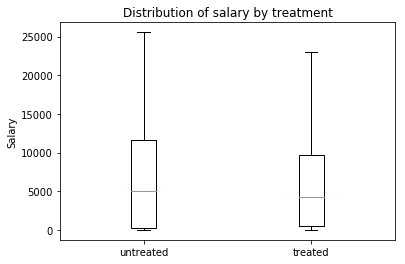

In [9]:
def outcome_by_treatment(untreated_salary, treated_salary):
    """draws boxplot of distribution of salary """
    plt.boxplot([untreated_salary, treated_salary], labels=['untreated', 'treated'], showfliers=False)
    plt.title('Distribution of salary by treatment')
    plt.ylabel('Salary')
    plt.show()

outcome_by_treatment(untreated_salary, treated_salary)

**Conclusion**:

If the treatment was effective, we should have noticed that the people in the treated group were more sucessful on average as they were placed in program (whereas for the untreated group, they were left to fend for themselves).

By merging the insights of his 3 steps analysis, the researcher can conclude that **the treatment shows no effect**. The salary distributions are similar in both groups, indicating that the treatment isn't effective.

Additionally, the treated group has a lower salary in average (except for the handful of lucky people who find a good job) which is shown by the boxplot: the whiskers extend higher in the untreated group and the median and lower wisker are situated higher up. Since the difference is somewhat small, this may just be due to chance.

### 2. A closer look at the data

After performing a simplistic analysis of the data where we ignored underlying factors (such as race and education) that could influence the outcome, we start looking at the whole table assuming that the other features have an impact on _['re78']_.

Note that we split our analysis into **categorical** and **interval** data (before determining the correlation between all variables).

**i - Categorical data :**

We can study the categorical data (race, degree and mariage) using their percentages in each population (as the treated and untreated groups have different sizes). To do this, we will simply use the mean of the values because averaging 0s and 1s gives us the percentage of each feature.

In [10]:
categories = ['black', 'hispan', 'married', 'nodegree']
percentages = lalonde_df.groupby('treat')[categories].mean()
percentages

,black,hispan,married,nodegree
treat,,,,
0,0.202797,0.142191,0.512821,0.596737
1,0.843243,0.059459,0.189189,0.708108


##### a. Race ratios:

We will start with race. As we do not have numbers for white participants, we substract the number of black and hispanic participants from the total of each treatment. This is possible because there is no overlap between the _['black']_ and _['hispan']_ categories.

In [11]:
black_u, black_t = percentages['black']
hispan_u, hispan_t = percentages['hispan']
white_u, white_t = (1 - black_u - hispan_u, 1 - black_t - hispan_t)

In [12]:
u_race_rates = [black_u, hispan_u, white_u]
t_race_rates = [black_t, hispan_t, white_t]
race_labels = 'Black', 'Hispanic', 'White'

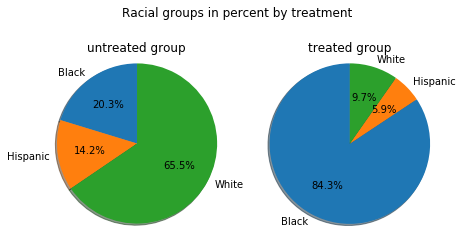

In [13]:
drawPies(u_race_rates, t_race_rates, race_labels, 'Racial groups in percent by treatment')

We see that there are significantly more black subjects in the treated group than in the untreated group. We also note that there are more hispanics in the untreated group.

##### b. Degree ratios:

To have a better understanding of the difference of salaries, we also need to look at the level of education of  participants in each treatment group.

In [14]:
degree_u, degree_t = percentages['nodegree']

In [15]:
u_degree_rates = [degree_u, 1 - degree_u]
t_degree_rates = [degree_t, 1 - degree_t]
degree_labels = 'Degree', 'No degree'

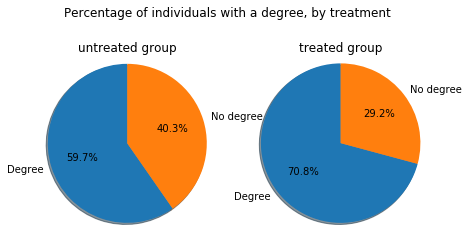

In [16]:
drawPies(u_degree_rates, t_degree_rates, degree_labels, 'Percentage of individuals with a degree, by treatment')

We notice that the population of treated group is less educated (there is over 10% more people with no degree in the treated set).

##### c. Marriage ratios:
Finally, we analyze our last feature: the rate of married people among both groups. 

In [17]:
married_u, married_t = percentages['married']
not_married_u, not_married_t = (1 - married_u, 1 - married_t)

In [18]:
u_marriage_rates = [married_u, not_married_u]
t_marriage_rates = [married_t, not_married_t]
mariage_labels = ['Married', 'Not married']

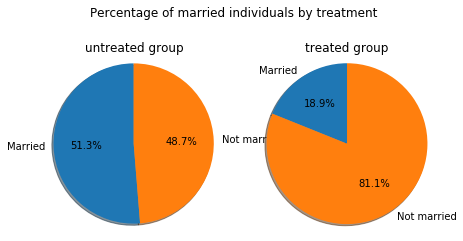

In [19]:
drawPies(u_marriage_rates, t_marriage_rates, mariage_labels, 'Percentage of married individuals by treatment')

We note once again less married people in the treated group.

##### d. Unemployment ratios:

Even though salaries are not categories but intervals, it is important to compare unemployment rates between both groups (which we define as categories: _employed_ and _unemployed_). To get better insights, we plot the evolution of this rate through the years by displaying _['re74']_ and _['re75']_.

In [20]:
salaries = ['re74', 're75']
cat_salaries = lalonde_df.copy()
unemployed_labels = 'Employed', 'Unemployed'

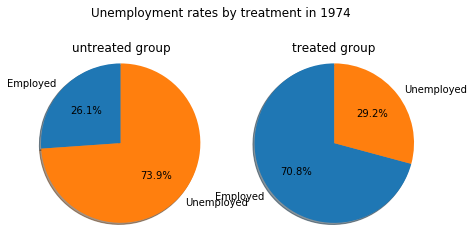

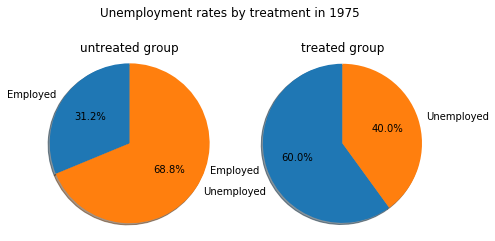

In [21]:
#We draw a boxplot for each column
for sal in salaries:
    #We classify the data following : employed = 1 and unemployed = 0
    cat_salaries[sal] = cat_salaries[sal].map(lambda x : 0 if x == 0 else 1)
    u_employed, t_employed = cat_salaries.groupby('treat')[sal].mean()
    drawPies([1-u_employed, u_employed],[1-t_employed, t_employed], 
             unemployed_labels, 'Unemployment rates by treatment in 19'+sal[-2:] )

We see that the assumption that both groups are balanced before treatment is also wrong for unemployment as we find much more unemployed people in the treated group than in the untreated group. 

**Conclusion:**

By looking at the categorical data, we find that the underlying factors are not similar at all among both groups (the treated group is significantly more black, less educated, less employed and less married). All these factors influence employment and should be taken into consideration.

These factors influence salary in the following ways:
- Due to racial inequality (especially given the period, the _1970s_), non-white people are more likely to work in worse paying jobs and/or be underpayed.
- Better education gets better jobs.
- People who already had jobs in 1974/5 are more likely to still have a job in 1978 (and may even have had a raise).
- Marriage is an indicator of stability, which may influence job prospects. People often get married when they have a stable job. 

**ii - Interval data :**

We now turn to non binary data and the their distribution to get more insights on the data. To do this, we first draw a boxplot and a relative fequency histogram for all variables.

_Note that we remove outliers from the box plot as we care more about the general distibution of values in the set._

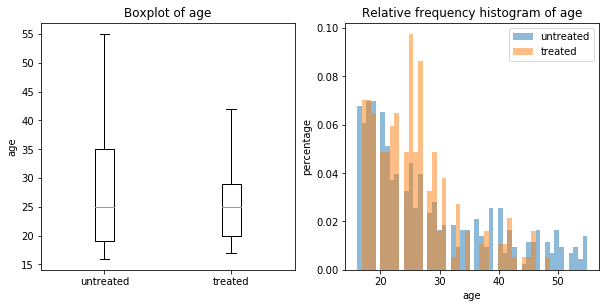

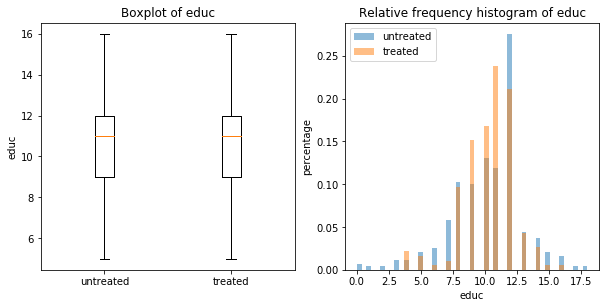

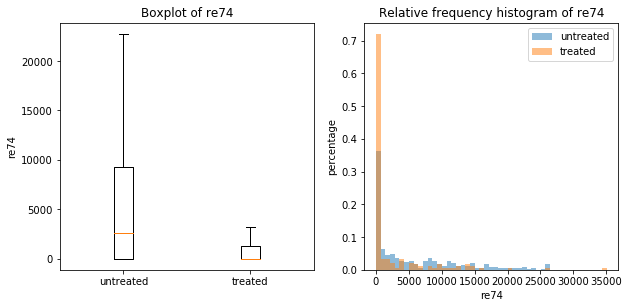

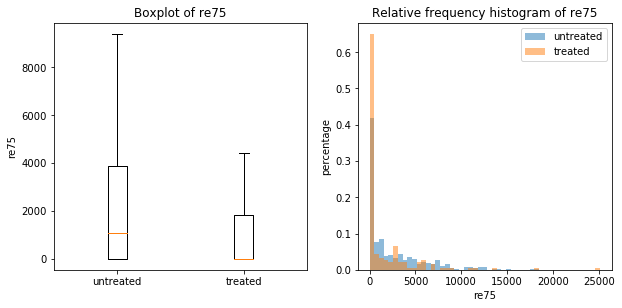

In [22]:
intervals = ['age', 'educ', 're74', 're75']
interval_plots(lalonde_df)

From these plots, we see that:
- Salaries are very unbalanced between the groups: the treatment group earns much less than the untreated group.
- The age distribution is different as the treated group is a bit younger (a lot of individuals are in their _20s_).
- Overall, the education level is similar. However, there are more well-educated people in the untreated group; we also note that the number of years of education does not indicate the acquirement of a degree.

##### a. Evolution:

Even though it is useful to plot the salaries through the years, it is much more useful to understand how the salary of each participant changes. It is especially interesting to see how the outliers in each year are connected. To do so, we visualize our data using a parallel plot (**orange** represents the treated group while **blue** represents the untreated group).

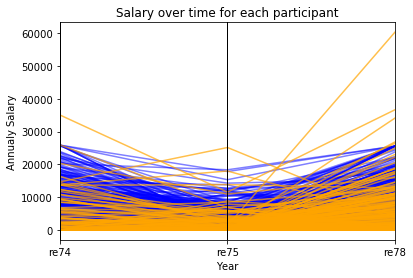

In [23]:
from pandas.plotting import parallel_coordinates
parallel_coordinates(lalonde_df[untreated(lalonde_df)][['id','re74', 're75', 're78']], 'id', color='Blue', alpha=0.5)
parplot = parallel_coordinates(lalonde_df[treated(lalonde_df)][['id','re74', 're75', 're78']], 'id', color='Orange' , alpha=0.7)
parplot.legend_.remove()
plt.title('Salary over time for each participant')
plt.xlabel('Year')
plt.ylabel('Annualy Salary')

Looking at the plots, we can that:
- The treated group started with a lower salary (the bracket of salaries up to 15K is all blue).
- 1975 was a "bad year" for everybody (there is an indent in the plot).
- The outliers are partially people who were already well payed in 1974 and partialy people who _"made it"_.
- Most members of the treated group have seen there salaries go up between 1975 and 1978. We also see a slight upwards movement for the untreated group.

#####  b. Salary and categorical features

As we supposed that categorical features influenced the salary, we try to see to what extent our hypothesis holds.

**Plotting by race:**

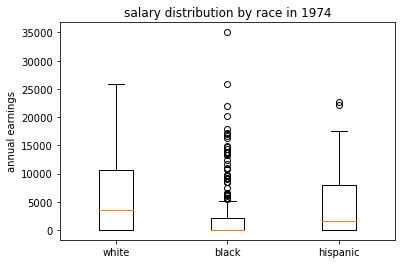

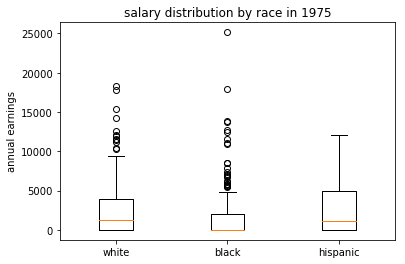

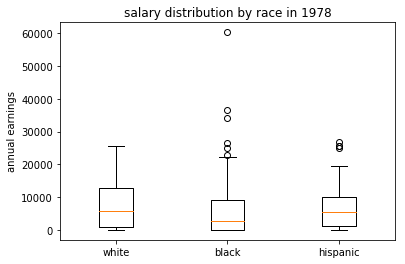

In [24]:
white = (lalonde_df['black'] == 0) & (lalonde_df['hispan'] == 0)
years = ['re74', 're75', 're78']

for year in years:
    plt.boxplot([lalonde_df[white][year], lalonde_df[lalonde_df['black'] == 1][year],
                 lalonde_df[lalonde_df['hispan'] == 1][year]], 
                labels=['white', 'black', 'hispanic'])
    plt.title('salary distribution by race in 19'+year[-2:])
    plt.ylabel('annual earnings')
    plt.show()

We can see that :
- There is a racial discrepancy in salary
- The outliers are all black individuals

**Plotting by martial status and degree:**

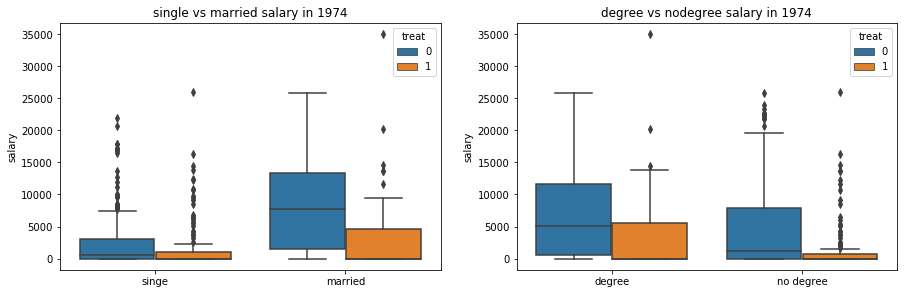

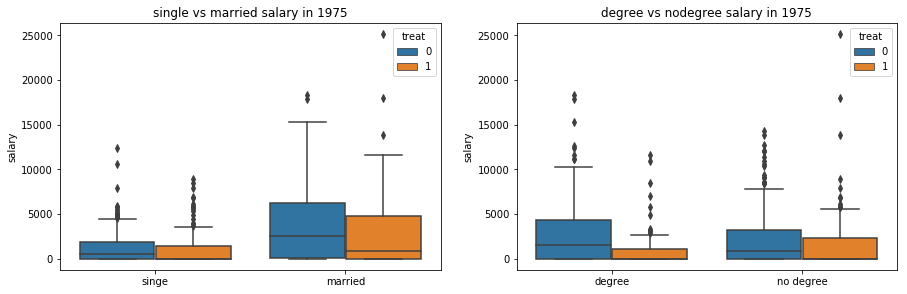

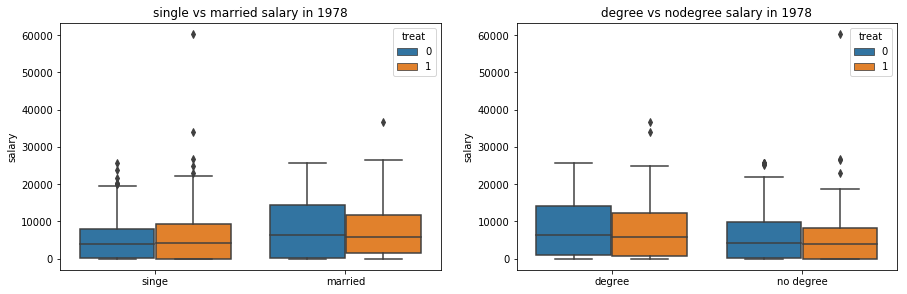

In [25]:
for year in years:
    #marriage
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.title('single vs married salary in 19'+year[-2:])
    sns.boxplot(data=lalonde_df, x='married', y=year, hue='treat')
    plt.ylabel('salary')
    plt.xlabel('')
    plt.xticks(range(2),('singe', 'married'))
    
    #degree
    plt.subplot(2,2,2)
    plt.title('degree vs nodegree salary in 19'+year[-2:])
    sns.boxplot(data=lalonde_df, x='nodegree', y=year, hue='treat')
    plt.xticks(range(2),('degree', 'no degree'))
    plt.xlabel('')
    plt.ylabel('salary')

We can see that:
- No matter the treatment or the year, married people earn more than single people and people with degrees make more money that people with no degree.
- Post-treatment (year 1978) the intra group differences between treated and untreated are the smallest out of all years, but the difference between groups – single & married, degree & no degree– is still visible. 

**Plotting by age**


It is well known that age influences a person's prospects at finding a job but also influence their potential salary. Thus, we map the salary by age (and treatment) for the 3 observed years.

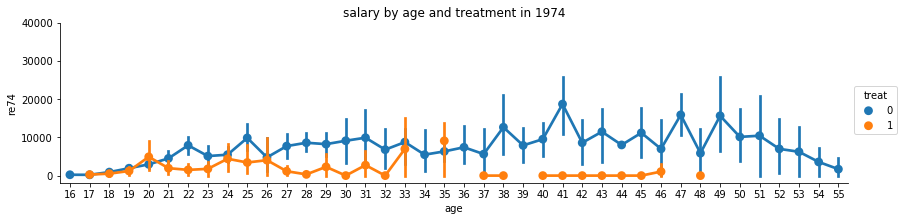

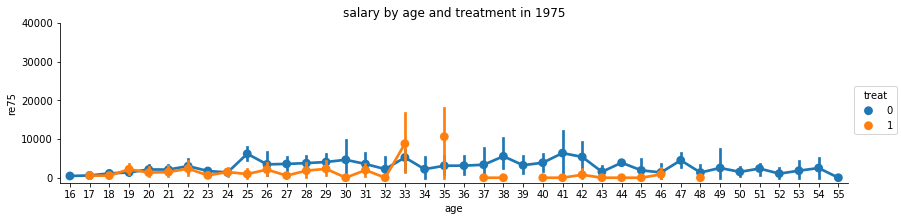

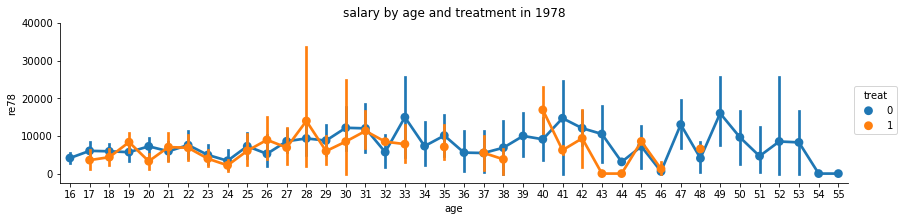

In [26]:
for year in years:
    sns.factorplot(data=lalonde_df, x='age', y=year, hue='treat',aspect=4, size=3)
    plt.title('salary by age and treatment in 19'+year[-2:])
    plt.yticks(np.linspace(0, 40000, 5))
    plt.show()

We can see that:

- Pre-treatment, the treated group makes less that the untreated group.
- Post-treatment, young people in the treated group easily catch up on people from the untreated group.
- The treatment seems to have an effect (in general, people in the treated group catch up, or at least find employment)

**Conclusion:**

By looking at the interval data, and more specificaly at the salaries of participants, we can say that the underlying feature (race, education, marital status) influence the salary. However, our two groups are not balanced which interferes with our first analysis.

**iii - Data correlation:**

After working on each value alone, we want to understand how each value is (linearly) linked to others looking at each pair of features. To do this, we draw as pairplot as correlation alone does not give us any insights.

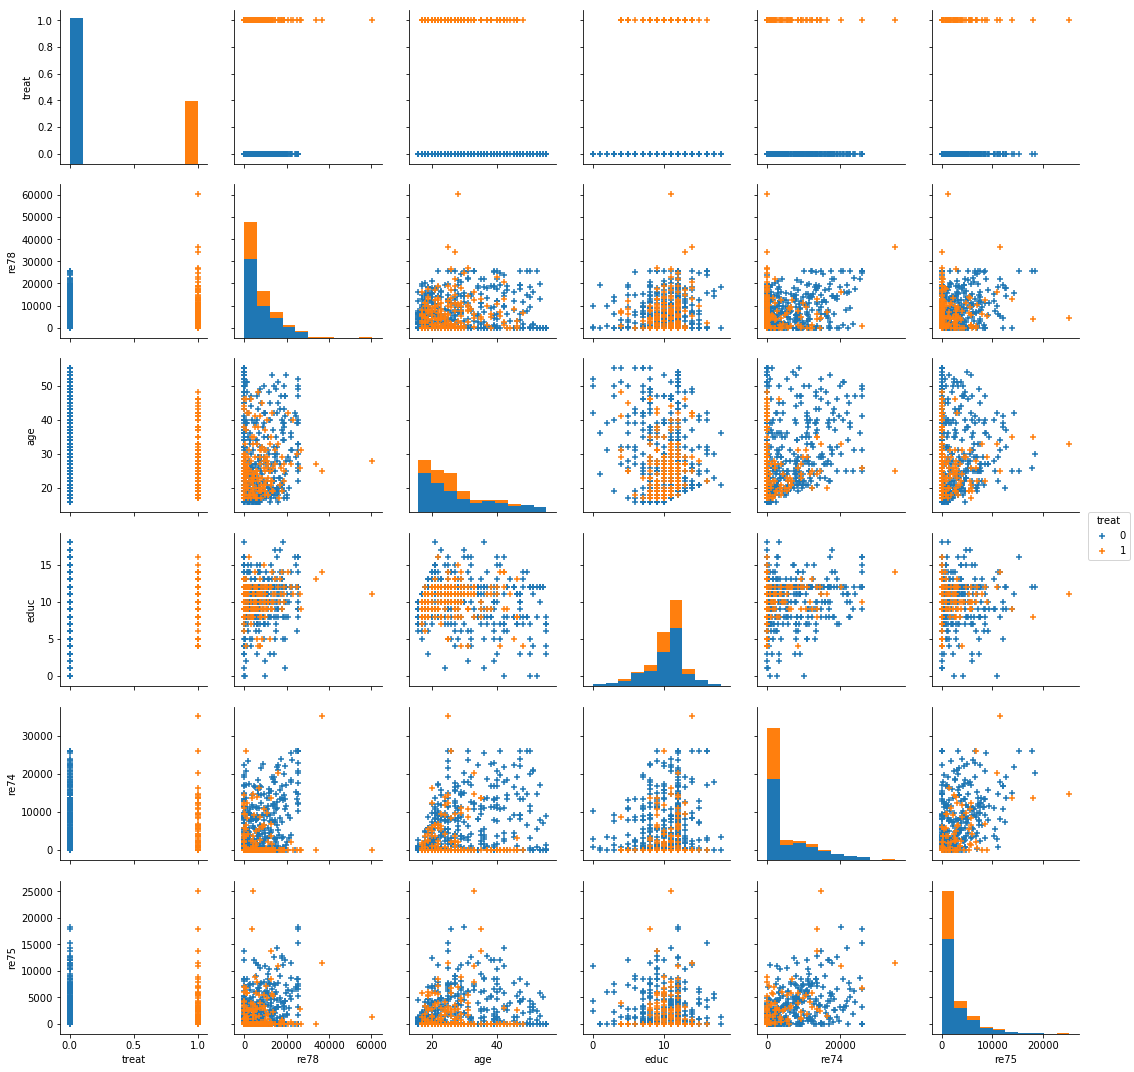

In [27]:
sns.pairplot(lalonde_df[['treat', 're78']+intervals], markers='+', hue='treat')

This plot does not tell us a lot other than the fact that we do not see any linear dependence. Thus, we do not spend more time on this part of our analysis.

### 3. A propensity score model

As we have seen, our naive analysis was based on the false assumption that the distribution was fair in both sets (which we determined was completely false). Thus, it is necessary to create fair sets for our observational study, which is what we do by calculating the propensity score (based on the underlying factors before treatment: _['age', 'educ', 'hispan', 'black', 'nodegree', 're74', 're75']_)

In [28]:
prop_table = lalonde_df.copy()
X = prop_table.iloc[:, 2:-1] #input: underlying features
y = np.ravel(prop_table.iloc[:, 1:2]) #output: treatment classification
print('First elements of Y :\n', y[0:5],'\nFirst elements of X :\n', X[0:5])

First elements of Y :
 [1 1 1 1 1] 
First elements of X :
    age  educ  black  hispan  married  nodegree  re74  re75
0   37    11      1       0        1         1   0.0   0.0
1   22     9      0       1        0         1   0.0   0.0
2   30    12      1       0        0         0   0.0   0.0
3   27    11      1       0        0         1   0.0   0.0
4   33     8      1       0        0         1   0.0   0.0


In [29]:
logistic = LogisticRegression()
logistic.fit(X, y)
print('Accuracy of prediction: ', logistic.score(X, y))

Accuracy of prediction:  0.807817589577


In [30]:
print("Example of prediction : ", logistic.predict(X[0:6]), ' reality :', y[0:6])
print('Example of prediction estimates : \n', logistic.predict_proba(X[0:6]))

Example of prediction :  [0 0 1 1 1 1]  reality : [1 1 1 1 1 1]
Example of prediction estimates : 
 [[ 0.55664958  0.44335042]
 [ 0.85534047  0.14465953]
 [ 0.27764537  0.72235463]
 [ 0.33584948  0.66415052]
 [ 0.30171439  0.69828561]
 [ 0.29988169  0.70011831]]


We add the propensity score as a new column. We can interpret this scores as the "probability of being a treated subject".

In [31]:
prop_table['propensity_scores'] = pd.Series(logistic.predict_proba(X)[:,1])
prop_table.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_scores
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


### 4. Balancing the dataset via matching

**i - Solving the bipartite graph problem:**

Using the propensity scores we just determined, we try to find a matching to interpret our data. This is nothing more than matching a bipartite graph to get a balanced set. Thus, we turn to _**networkx**_, a Python package which provides matching functions.

In [32]:
import networkx as nx

The first step of our solution is to create a graph where the _ids_ are the nodes.

In [33]:
B = nx.Graph()
B.add_nodes_from(prop_table['id'])

After this, we add (weighted) edges between each treated and untreated subject. The weight of each edge correponds to the (absolute) difference between the nodes.

_Note that we use '-x' to transform our minimization problem into a maximum problem to be able to use the **networkx** functions._

In [34]:
for row_i in prop_table[treated(prop_table)].iterrows():
    for row_j in prop_table[untreated(prop_table)].iterrows():
        B.add_edge(row_i[1]['id'],row_j[1]['id'], 
                   weight= 1 - np.abs(row_i[1].propensity_scores - row_j[1].propensity_scores))

Finally, we find the matching using a provided function. 

In [35]:
matching_dict = nx.max_weight_matching(B)

We display the number of matched subjects to be sure the method works indeed. We also display example matches to understand the form of the data.

_Note: we divide the length of the table by 2 as each pair is displayed twice._

In [36]:
matched = prop_table.copy()[prop_table['id'].isin(matching_dict)]
print('We have : ', len(matched)/2, ' matched subjects')

We have :  185.0  matched subjects


In [37]:
print('Example matches:')
list(matching_dict.items())[:5]

Example matches:


[('NSW136', 'PSID392'),
 ('PSID268', 'NSW84'),
 ('NSW74', 'PSID218'),
 ('NSW27', 'PSID371'),
 ('PSID282', 'NSW110')]

**ii - Looking at the salary:**

Now that our sets make more sense, we compare the outcome _['re78']_ of the treated and untreated groups using boxplots.

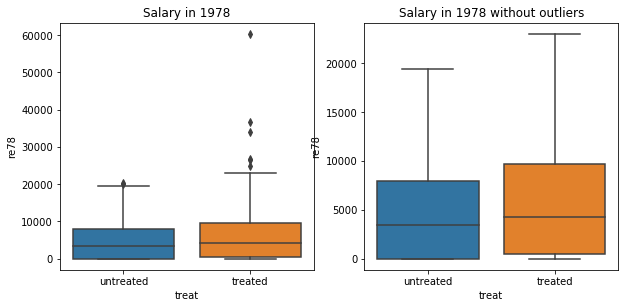

In [38]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
sns.boxplot(data=matched, x='treat', y='re78')
plt.xticks(range(2), ('untreated', 'treated'))
plt.title('Salary in 1978')
plt.subplot(2,2,2)
sns.boxplot(data=matched, x='treat', y='re78',  showfliers=False)
plt.xticks(range(2), ('untreated', 'treated'))
plt.title('Salary in 1978 without outliers')
plt.show()

Looking at the graph, we now see that the treated group's salary distribution in 1978 is slightly higher than that of the untreated group.

**iii - Looking at the feature distribution:**

The last part of this exercise is dedicated to analyzing the features just like we did in __Exercise 1.02__.

In [39]:
matched_percentages = matched.groupby('treat')[categories].mean()
matched_percentages

,black,hispan,married,nodegree
treat,,,,
0,0.470270,0.118919,0.167568,0.627027
1,0.843243,0.059459,0.189189,0.708108


Looking at our categorical data, we immediately see that the distribution of the features is skewed. Even though the racial distribution is the most blatant (almost 40% more blacks in the treated group), the other feature also differ quite consequently (from 2% to around 8%).

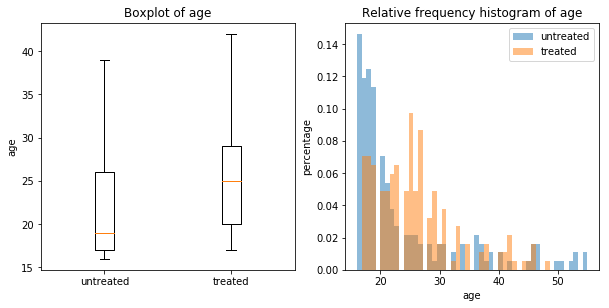

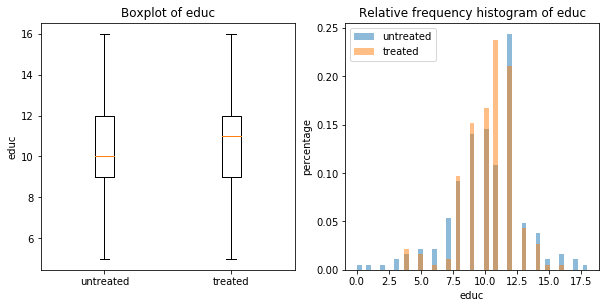

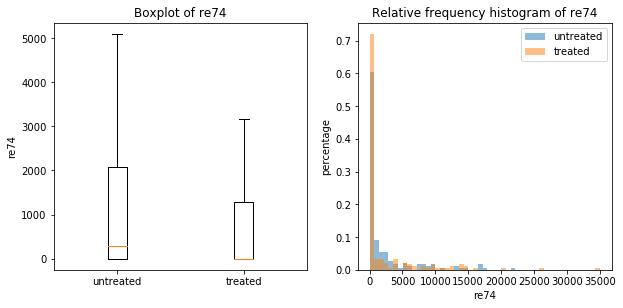

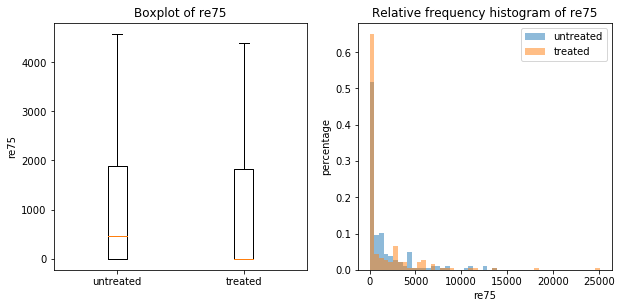

In [40]:
interval_plots(matched)

Now looking at the interval data, we see that is much more balanced than it was before, especially the education level of participants of both groups and their salary in 1975.

### 5. Balancing the groups further


Looking at the feature distribution following our propensity score matching, we can still see many discrepancies starting with the high ratio of black people remaining in the treated group comparing to the ratio in the untreated group. Additionally, we still have outliers in the treated group. This clearly means that our dataset is not sufficiently balanced yet.

**i - Merging the data:**


The first step of our balancing problem is to merge the DataFrames to work more easily with the data. We display the head of the new DataFrame for clarity (and display the number of matched subjects to make sure our matching makes sense).

In [41]:
matched['match'] = matched['id'].map(matching_dict)
balanced_match = matched[treated(matched)].merge(matched[untreated(matched)], left_on='id', right_on='match')
balanced_match['difference'] = abs(balanced_match['propensity_scores_x'] - balanced_match['propensity_scores_y'])
print('We have : ', len(balanced_match), ' matched subjects')
balanced_match.head()

We have :  185  matched subjects


,id_x,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,...,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y,propensity_scores_y,match_y,difference
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,...,1,0,1,1,13685.480,12756.0500,17833.200,0.402995,NSW1,0.040355
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,...,0,0,0,0,0.000,0.0000,0.000,0.143760,NSW2,0.000900
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,...,1,0,0,0,1681.051,0.0000,0.000,0.711797,NSW3,0.010558
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,...,0,0,0,0,0.000,1147.5970,15554.550,0.183306,NSW4,0.480844
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,...,1,0,0,1,587.780,841.4516,7933.914,0.678552,NSW5,0.019733


We now compare the percentages of each feature in both groups to determine the problematic features. 

In [42]:
compare_groups(balanced_match)

,untreated,treated
black,0.47027,0.843243
hisp,0.118919,0.0594595
married,0.167568,0.189189
no_degree,0.627027,0.708108


**ii - Matching by race:**

As expected, the first improvement we need to make has to do with race. To do this, we remove mismatched black people (meaning black people who are matched to another race, either white or hispanic). It is also important to monitor the evolution of the dataset.

In [43]:
race_bool = (balanced_match['black_x'] == 1) & (balanced_match['black_y'] == 0)
balanced_match = balanced_match.drop(balanced_match[race_bool].index)
print('We have : ', len(balanced_match), ' matched subjects')

We have :  116  matched subjects


In [44]:
compare_groups(balanced_match)

,untreated,treated
black,0.75,0.75
hisp,0.0775862,0.0948276
married,0.258621,0.12931
no_degree,0.637931,0.646552


**iii - Matching by marriage:**

When looking at the new dataset, we see a clear difference in the rate of married people between the untreated and the treated group. This is consistant with what we noticed earlier when looking at the data. Thus, it is very important to remove mismatched married people.

In [45]:
marriage_bool = (balanced_match['married_x'] == 1) & (balanced_match['married_y'] == 0)
balanced_match = balanced_match.drop(balanced_match[marriage_bool].index)
print('We have : ', len(balanced_match), ' matched subjects')

We have :  114  matched subjects


In [46]:
compare_groups(balanced_match)

,untreated,treated
black,0.754386,0.754386
hisp,0.0701754,0.0877193
married,0.263158,0.114035
no_degree,0.640351,0.649123


We can now see that all features are similar (except for a low difference in the rate of hispanics across both groups). However, we deem the categorical data of our dataset to be balanced enough for the matching to make sense.

**iv - Looking at intervals and outliers:**

Now that we know our categorical data is balanced, we need to make sure the interval data is still constistent across our groups. However, we still need to perform an important task for the data to be meaningful: we need to remove the outliers (which create a discrepancy on the mean of our data).

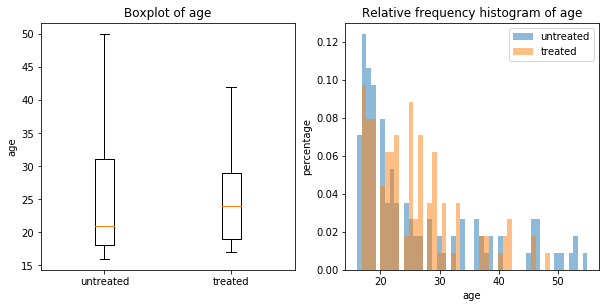

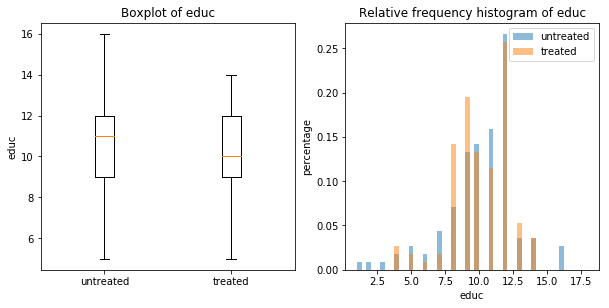

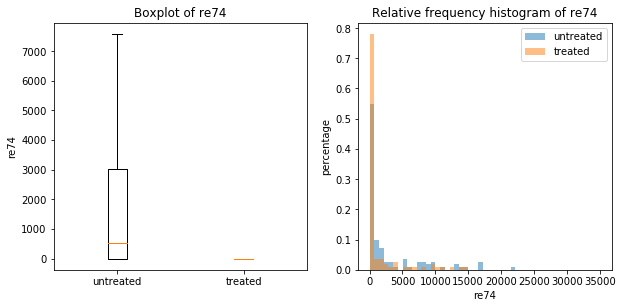

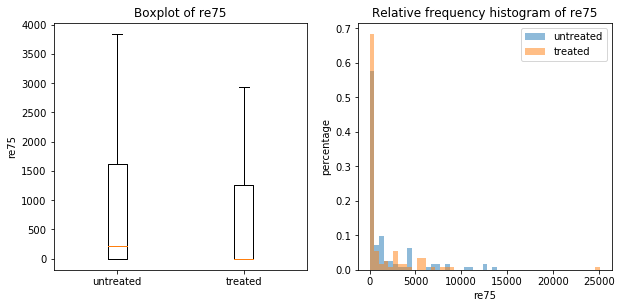

In [47]:
def plot_balanced_interval(df):
    df1 = df.iloc[:,:11]
    df2 = df.iloc[:, 13:-3]
    df2.columns = lalonde_df.columns
    df1.columns = lalonde_df.columns
    balanced_df = pd.concat([df1, df2])
    interval_plots(balanced_df)
    
balanced_match = balanced_match.drop(balanced_match[balanced_match.re78_x > 30000].index)
plot_balanced_interval(balanced_match)

Looking at the (more robust) statistics of our interval data, we see very similar distributions over almost features, the age being the main difference between both sets. Once again, we assume this difference to be of minor significance, allowing us to use the dataset for our analysis as we can finally compare people with similar features.

### 6. A less naive analysis

Knowing that we compare (almost) perfectly matched groups, we only need to look at the distribution of _['re78']_, the outcome we wanted to analyze all along. To interpret our data, we use a 5 number summary (along with its visual representation, our faithful boxplot).

In [48]:
stats = pd.concat([balanced_match.re78_y.describe(),balanced_match.re78_x.describe()], axis=1)
stats.columns = ['untreated', 'treated']
stats

,untreated,treated
count,113.000000,113.000000
mean,5072.119851,6082.417562
std,5952.720433,6083.952825
min,0.000000,0.000000
25%,0.000000,762.914600
50%,2404.261000,4814.627000
75%,7759.542000,9930.046000
max,20243.380000,26817.600000


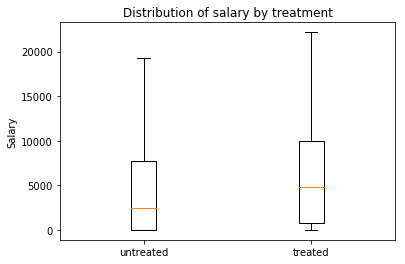

In [49]:
outcome_by_treatment(balanced_match['re78_y'], balanced_match['re78_x'])

On top of having a higher mean, the quartiles of the treated population are all superior to those of the untreated population. Moreover, the median is significantly higher in the treated group, and so is the maximum salary.

The treated group makes a mean of 31% as can be calculated using this formula:

$$(6489.919437 - 4944.548418) / 4944.548418 *100 = 31.2540375\%$$

Thus, considering the graph and the numbers, it is clear that **the treatment has a benefic impact** on people.

The difference between the naive analysis and our final observation shows the significance of performing the analysis in a way to take into consideration correlates. In this case we this this by the matching we performed on both groups.

## Exercise 2: Applied ML

The idea of this exercise is to build a text classifier. We will first process the data before building the text classifier _per se_ by training it and finally analyze its performance.

### 1. Transforming the Data

We first import the data we need to work with. 

Not that we **remove the headers, footers and quotes**, as suggested in the provided [sklearn tutorial](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html). This allows us to work with more realistic data (which means we do not have access to the metadata). As we will show in Exercise 2.03, this significantly decreases our accuracy.

In [50]:
# create the TF-IDF vectorizer
tfidf = TfidfVectorizer()

In [51]:
# Import the data we need to use the vectorizer on. Remove metadata as proposed by sci-kit tutorial
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroups_with_header = fetch_20newsgroups(subset='all')

We then compute the TF-IDF matrix of our dataset using a vectorizer. Note that we did not use the **sklearn.datasets.fetch_20newsgroups_vectorized** function which already returns the TF-IDF features as it would defeat the purpose of the exercise.

In [52]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(newsgroups_all.data)

As it was our understanding from the question that we needed to use all the data provided by sklearn instead of using only the subsets, we created our own testing and validation subsets. We created both sets using a **random_state**.

In [53]:
# Separate the training set
y_train, y_inter, X_train, X_inter = \
    train_test_split(newsgroups_all.target, X, test_size=0.2, random_state=1)

# Get the testing and validation sets
y_test, y_valid, X_test, X_valid = \
    train_test_split(y_inter, X_inter, test_size=0.5, random_state=1)

### 2. Training the classifier

Now that we have our data (and most importantly our training set), we need to train a random forest. To do this, we  use the RandomForestClassifier as it allows us to use the parameters we have seen in the class. Thus, the main problem is setting our 2 parameters : *max_depth* and *n_estimators*. To get a first idea on how the classifier works, we use 100 trees and a depth of 25 (standard values given in class).

In [54]:
# need to find estimators and depth first.
clf = RandomForestClassifier(n_estimators=100, max_depth=25)
clf.fit(X_train, y_train)
pred = clf.predict(X_valid)
metrics.f1_score(y_valid, pred, average='macro')

0.59047914230848586

We use the validation set to evaluate the performance of this first version and use 2 measures to quantify it : the F1 score and the prediction accuracy.

In [55]:
print('F1 score for basic parameters : ',metrics.f1_score(y_valid, pred, average='macro'))

F1 score for basic parameters :  0.590479142308


In [56]:
print('Accuracy for basic parameters : ', metrics.accuracy_score(y_valid, pred))

Accuracy for basic parameters :  0.612732095491


As the predictions are not satisfying (as expected), we fine tune our model using the validation set. We tried using skikit's **GridSearchSV** function but it did not give any good results (the best parameters were the highest ones and yet, the results were poor). Thus, we decided to implement our own grid search using a double for loop even though the computation is very heavy and takes as much time.

In [57]:
def GridSearch(X_train, y_train, X_valid, y_valid, range_estimator, range_depth):
    """Implements grid search, goes over range_estimator and range_depth, returns best parameter in the ranges
    X_train: set to train on
    y_train: true values training
    X_valid: set to test on
    y_valid: true values for testing
    range_estimator: range to go over for estimator
    range_depth: range to go over for depth
    """
    rows = []
    for i in range_estimator:
        for j in range_depth:
            clf = RandomForestClassifier(n_estimators=j, max_depth=i, n_jobs=-1)
            clf.fit(X_train, y_train)
            pred = clf.predict(X_valid)
            pred_result = metrics.accuracy_score(y_valid, pred)
            print(i," ; ", j)
            rows.append([i, j, pred_result])
    columns=['Depth', 'Estimators', 'Prediction']
    all_predictions = pd.DataFrame(rows, columns=columns)
    all_predictions = all_predictions.sort_values(by=['Prediction'], ascending=False)
    return all_predictions.head(5)

Finding a good fit over a large number of values takes a lot of time to compute (computations take the whole day). You will find the code to compute the prediction which you can run (at your own risk!).

In [58]:
#all_predictions = GridSearch(X_train, y_train, X_valid, y_valid, range(30, 160, 30), range(300, 1100, 200))
#all_predictions.to_pickle("all_predictions.pkl")

We saved the results in a pickle file so that you would not have to run the function. We display below the 10 best predictions to be able to analyze the performance.

In [59]:
all_predictions = pd.read_pickle("all_predictions.pkl")
all_predictions.head(10)

,Depth,Estimators,Prediction
44,130,700,0.690186
30,110,900,0.690186
62,150,900,0.689125
61,150,800,0.688064
59,150,600,0.687003
14,90,900,0.685942
47,130,1000,0.685411
45,130,800,0.685411
37,120,800,0.684881
28,110,700,0.684881


We visualize the estimators and the depth along the accuracy to understand the link between them.

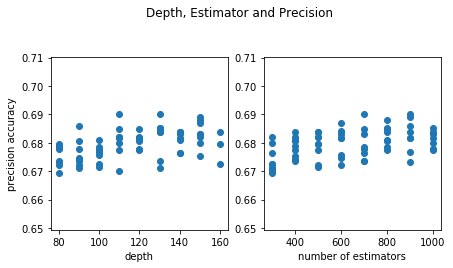

In [60]:
fig = plt.figure(figsize=(7,7))
plt.suptitle('Depth, Estimator and Precision')
plt.subplot(2,2,1)
plt.ylabel('precision accuracy')
plt.scatter(all_predictions['Depth'], all_predictions['Prediction'])
plt.xlabel('depth')
plt.subplot(2,2,2)
plt.scatter(all_predictions['Estimators'], all_predictions['Prediction'])
plt.xlabel('number of estimators')
plt.show()

As the graph above is not very informative, we visualize the data in 3D to see the relationship between the 3 variables (and not simply pairwise).

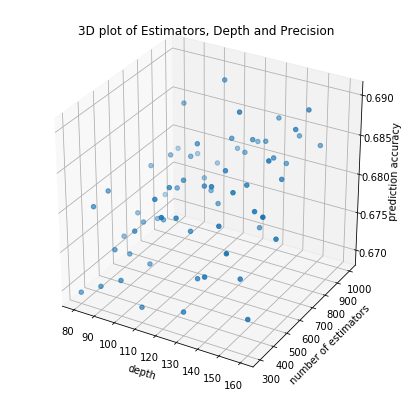

In [61]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_predictions['Depth'], all_predictions['Estimators'], all_predictions['Prediction'])
ax.set_title('3D plot of Estimators, Depth and Precision')
ax.set_xlabel('depth')
ax.set_ylabel('number of estimators')
ax.set_zlabel('prediction accuracy')

As we can see, we have the best results when *n_estimators* is set around 700 and *max_depth* is set around 130.

In [62]:
clf = RandomForestClassifier(n_estimators=700, max_depth=130, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict(X_valid)

In [63]:
print('F1 score for basic parameters : ', metrics.f1_score(y_valid, pred, average='macro'))

F1 score for basic parameters :  0.665094479605


In [64]:
print('Accuracy for basic parameters : ', metrics.accuracy_score(y_valid, pred))

Accuracy for basic parameters :  0.678514588859


What striked us is that most tutorials on the Internet show 80+% accuracy using Random Forest Classifiers as well while we cannot get past 68%. As explained before, this is the result of taking out all metadata. Even though these predictions are more realistic, we will see in **Exercise 2.03** how this model compares with a model with metadata.

Now that we have determined the best results possible of our model, we construct a confusion matrix (and display it using a heatmap).

In [65]:
pred_test = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, pred_test)
df = pd.DataFrame(cm)
df.index = newsgroups_all.target_names
df.columns = newsgroups_all.target_names

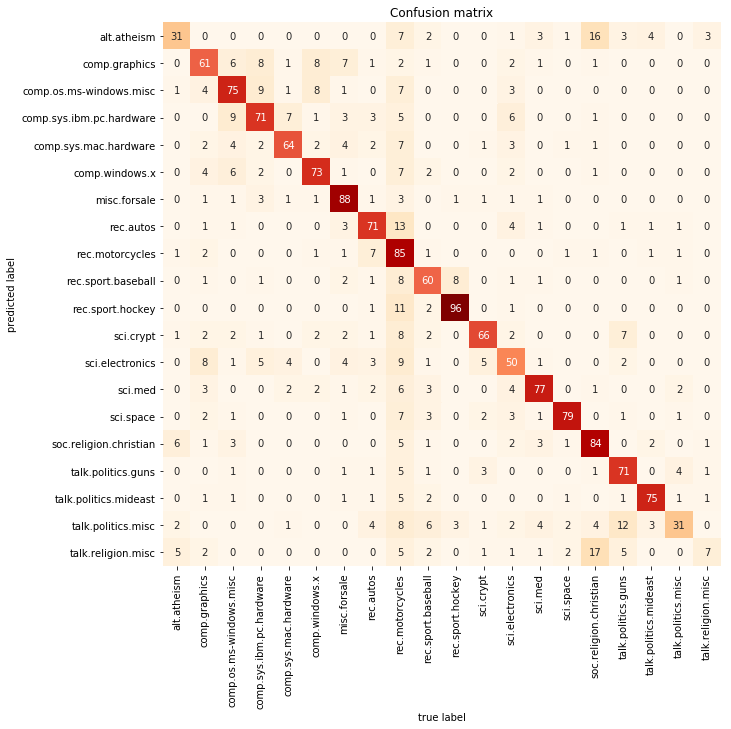

In [66]:
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix')
sns.heatmap(df, cmap='OrRd', annot=True, cbar=False)
plt.ylabel('predicted label')
plt.xlabel('true label')
plt.show()

We see the well-classified values (true positives) on the diagonal and notice that some classes are predicted more accurately than others. For example, our classifier classifies **sport.hockey** very well but has great trouble classifying **talk.religious.misc** correctly. This result is consistent with the mixups we notice (false negatives & false positives) which happen most frequently within similar topics (namely **religion.misc** and **religion.christian**).

Another important attribute of the random forest to understand is the `feature_importances_` (most significant features). Without much surprise, we see keywords such as **car** or **god** which clearly indicate a topic. For example, a text containing **god** will most likely be religious.

In [67]:
features = pd.DataFrame(list(zip(tfidf.get_feature_names(), clf.feature_importances_)))
features = features.sort_values(by=[1], ascending=False)
features.head(10)

,0,1
127656,windows,0.004266
34680,car,0.004026
116790,the,0.003825
106112,sale,0.003770
89588,of,0.003732
30800,bike,0.003506
116771,that,0.003309
117905,to,0.003257
67604,is,0.003106
58020,god,0.003040


In this second list, we see the least indicative (and yet still indicative features). These are very cryptic as they probably only show up once, yet strongly indicate the type of text.

In [68]:
features = features.sort_values(by=[1], ascending=True)
features[features[1] > 0].head(10)

,0,1
12242,58333333,4.505961e-11
92342,palmachim,5.221123e-11
91557,oveshadowed,6.535127e-11
40957,cryptech,9.290008e-11
22087,aa11852,9.529008e-11
48725,eldoret,1.294411e-10
97537,protoge,1.496017e-10
18421,921,1.530701e-10
24510,aliyah,1.618369e-10
110427,snorris,1.646266e-10


Now that we understand the importance of each feature, we want to understand the relationship between the (200) most important features. As expected, the importance of features decreases slowly.

In [69]:
feature_importance = pd.Series(clf.feature_importances_).sort_values(ascending=False)

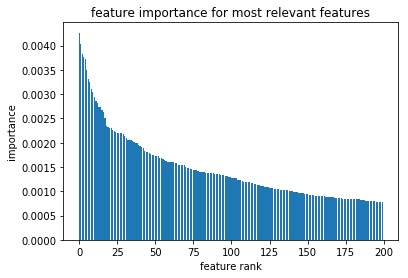

In [70]:
plt.bar(range(0, 200),feature_importance.head(200))
plt.title('feature importance for most relevant features')
plt.xlabel('feature rank')
plt.ylabel('importance')
plt.show()

We also want to know how much features are really important (and how much are not as indicative). As we have a lot of features, we are forced to use a log scale to see relevant results.

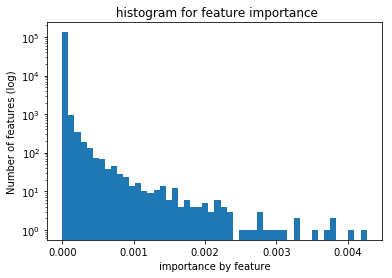

In [71]:
plt.hist(clf.feature_importances_, bins=50)
#note the log scale!
plt.yscale('log')
plt.title(' histogram for feature importance')
plt.xlabel('importance by feature')
plt.ylabel('Number of features (log)');

We can see very easily that most features are not used for the classification(aggregation on the left of the graph showing very little importance).

### 3. Prediction with labels

After training our classifier, we want to know how much better it fares by keeping the labels in the dataset. In order to do a relevant analysis, we assume that both sets are similar (which is why we use the same preprocessing steps and the same estimator values).

In [72]:
X = tfidf.fit_transform(newsgroups_with_header.data)

y_train, y_inter, X_train, X_inter = \
    train_test_split(newsgroups_with_header.target, X, test_size=0.2, random_state=1)

y_test, y_valid, X_test, X_valid = \
    train_test_split(y_inter, X_inter, test_size=0.5, random_state=1)

In [73]:
clf = RandomForestClassifier(n_estimators=700, max_depth=130, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict(X_valid)

We find immediately that the results are much better according to both metrics.

In [74]:
print('F1 score for basic parameters : ', metrics.f1_score(y_valid, pred, average='macro'))

F1 score for basic parameters :  0.854986285118


In [75]:
print('Accuracy for basic parameters : ', metrics.accuracy_score(y_valid, pred))

Accuracy for basic parameters :  0.86525198939


Once again, we display the confusion matrix to see exactly what are the best classified classes.

In [76]:
pred_test = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, pred_test)
df = pd.DataFrame(cm)
df.columns = newsgroups_all.target_names
df.index = newsgroups_all.target_names

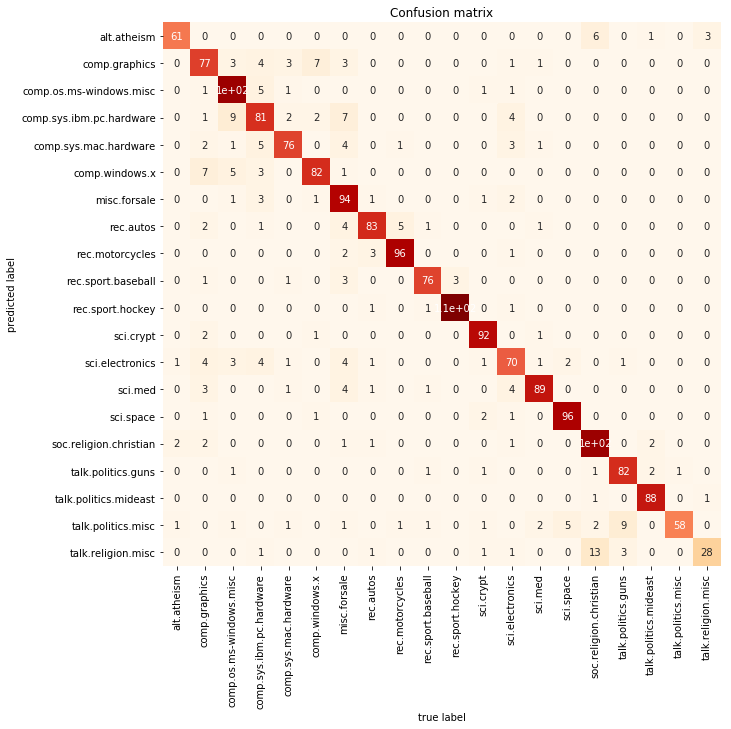

In [77]:
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix')
sns.heatmap(df, cmap='OrRd', annot=True, cbar=False)
plt.ylabel('predicted label')
plt.xlabel('true label')
plt.show()

Compared to the previous confusion matrix, we have a lot more well-classified values and less mixups. However, we notice that the hardest classes to label are the same (namely classes having to do with religion).

Once again, we inspect the `feature_importances_` attribute of our random forest for this classifier. The significant features make sense (even though we note the presence of linking words, which are not informative at all). On the other hand, the unsignificant features are even more esoterical.

In [78]:
#most significant features
features = pd.DataFrame(list(zip(tfidf.get_feature_names(), clf.feature_importances_)))
features = features.sort_values(by=[1], ascending=False)
features.head(10)

,0,1
139570,sale,0.004434
165812,windows,0.004421
65684,dod,0.004087
52100,car,0.003486
46061,bike,0.003447
55485,clipper,0.003384
145613,space,0.002764
119845,of,0.002705
133530,re,0.002667
152603,the,0.002639


In [79]:
#Worst still positive 
features = features.sort_values(by=[1], ascending=True)
features[features[1] > 0].head(10)

,0,1
68577,eeharvey,4.152783e-11
99222,kunkee,6.651764e-11
46337,bisht,6.754589e-11
19542,4729,7.305226e-11
35454,aa24096,8.555766e-11
44010,bangaldesh,9.623086e-11
152696,themsselves,1.007090e-10
64033,diduck,1.008650e-10
30635,93332,1.156105e-10
123486,parkside,1.169986e-10


We now look at the relationship between the most relevant features and notice that, unlike on the previous graph, the slope of the function is a lot steeper. This means that only a few features are very relevant.

In [80]:
feature_importance = pd.Series(clf.feature_importances_).sort_values(ascending=False)

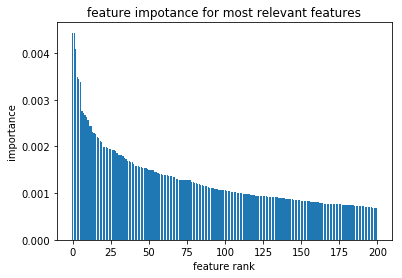

In [81]:
plt.bar(range(0, 200),feature_importance.head(200))
plt.title('feature impotance for most relevant features')
plt.xlabel('feature rank')
plt.ylabel('importance')
plt.show()

To comfort ourselves in this idea, we plot a histogram to see how many features we have in each bin. We see that the feature distributon does not change a lot by adding the metadata even though unsignificant and significant features are more separated than before. We also have that the more significant values are even more significant.

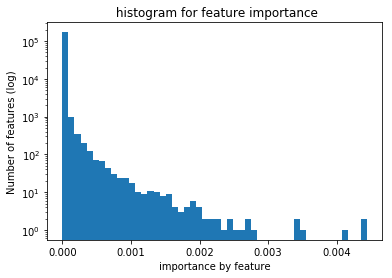

In [82]:
plt.hist(clf.feature_importances_, bins=50)
plt.yscale('log')
plt.title(' histogram for feature importance')
plt.xlabel('importance by feature')
plt.ylabel('Number of features (log)');